In [73]:
# Libraries
import pandas as pd
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np

from googleapiclient.discovery import build
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from transformers import pipeline

In [74]:
API_KEY=os.getenv("YOUTUBE_API_KEY")
video_id='video_id_here'

youtube=build('youtube', 'v3', developerKey=API_KEY)

# Function to get comments from a YouTube video
def get_comments(video_id, max_comments=1000):
    comments=[]
    next_page=None

    while len(comments)<max_comments:
        request=youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            pageToken=next_page,
            maxResults=100,             # Maximum comments per request
            textFormat='plainText'
        )
        response=request.execute()

        for item in response['items']:
            top_comment=item['snippet']['topLevelComment']['snippet']
            comments.append({
                'author':top_comment['authorDisplayName'],
                'text':top_comment['textDisplay'],
                'likeCount':top_comment['likeCount'],
                'publishedAt':top_comment['publishedAt']
            })

        next_page=response.get('nextPageToken')
        if not next_page:
            break

        return pd.DataFrame(comments)
    
# Function to clean comments
def clean_text(text):
    text=text.lower()                              # Lowercase
    text=re.sub(r"http\S+", "", text)              # Remove URLs
    text=re.sub(r"@\w+", "", text)                 # Remove usernames
    text=re.sub(r"[^a-zA-Z\s]", "", text)          # Keep only letters and spaces
    text=re.sub(r"\s+", " ", text).strip()         # Remove extra spaces

    return text

# Convert VADER scores to sentiment labels
def vader_label(score):
    if score>=0.05:
        return 'positive'
    elif score<=-0.05:
        return 'negative'
    else:
        return 'neutral'

# Perform BERT setiment analysis
def bert_safe(text):
    try:
        return bert_sentiment(text[:512])[0]['label'] # Truncate long comments to at max 512 characters
    except:
        return None

# Count emotion words in text
def emotion_count(text, word_list):
    tokens=text.split()
    return sum(w in tokens for w in word_list)

def print_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_indices=topic.argsort()[-n_top_words:]
        top_words=[feature_names[i] for i in top_indices]
        print(f"Topic #{topic_idx}: {', '.join(top_words)}")
        

BASIC EDA ON RAW COMMENTS

In [75]:
df=get_comments(video_id='qSqVVswa420', max_comments=2000)              # Using Maverick Top Gun video as example
df.to_csv('csv_files/youtube_comments.csv', index=False)            
df.shape, df.columns, df.head()

((100, 4),
 Index(['author', 'text', 'likeCount', 'publishedAt'], dtype='object'),
                  author                                               text  \
 0            @DTM-ch7jy  This is one rare sequel that Hollywood did not...   
 1  @tetsuyakohmatsu7268  革ジャンの背中に🇯🇵と🇹🇼があった時はほんと興奮した。\nアメリカ映画が中国には屈していなか...   
 2           @sandeokiii  i wish i could watch this movie for the first ...   
 3        @ewanijhof4687                               its nerological fact   
 4        @ewanijhof4687  only pilots over 30 should be allowed to go ag...   
 
    likeCount           publishedAt  
 0          0  2025-12-13T09:03:51Z  
 1          0  2025-12-08T10:09:14Z  
 2          0  2025-12-01T16:19:14Z  
 3          0  2025-11-30T00:18:07Z  
 4          0  2025-11-30T00:17:30Z  )

In [76]:
# Comment length in characters and words
df['char_len']=df['text'].apply(len)
df['word_len']=df['text'].astype(str).str.split().str.len()

df[['char_len', 'word_len']].describe()

,char_len,word_len
count,100.000000,100.000000
mean,67.450000,12.050000
std,110.869144,19.930371
min,2.000000,1.000000
25%,17.000000,3.000000
50%,34.500000,6.000000
75%,68.250000,12.250000
max,675.000000,120.000000


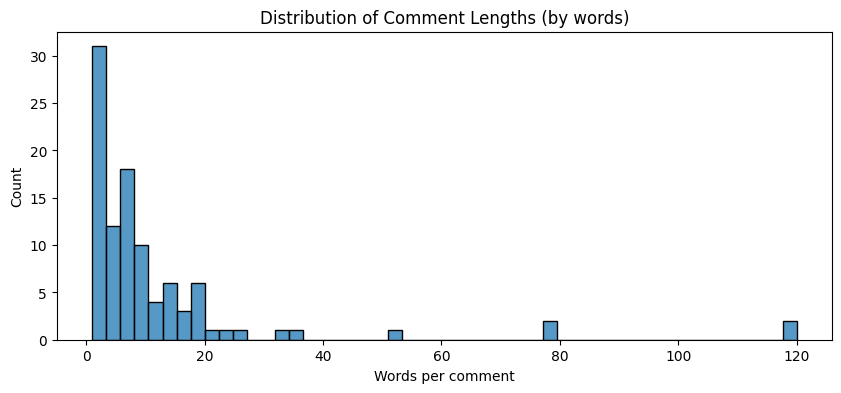

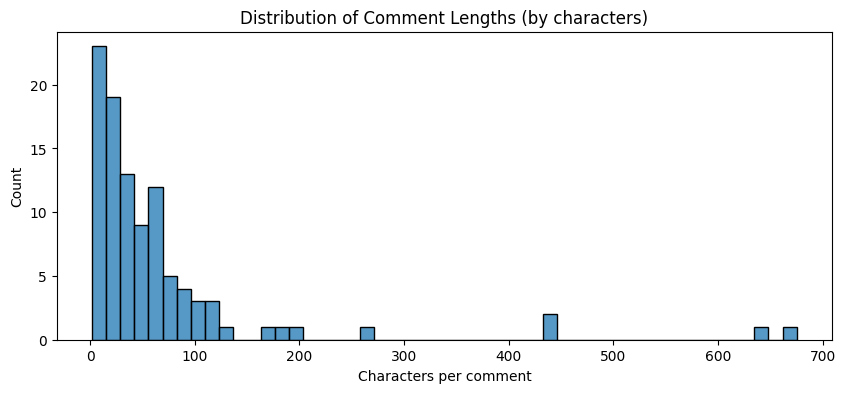

In [77]:
plt.figure(figsize=(10,4))
sns.histplot(df['word_len'], bins=50)
plt.title('Distribution of Comment Lengths (by words)')
plt.xlabel('Words per comment')
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(df['char_len'], bins=50)
plt.title('Distribution of Comment Lengths (by characters)')
plt.xlabel('Characters per comment')
plt.show()

CLEAN THE DATASET

In [78]:
# Cleaning the comments
df["clean_text"]=df["text"].apply(clean_text)
df[['text', 'clean_text']].head()
# df.head()

,text,clean_text
0,This is one rare sequel that Hollywood did not...,this is one rare sequel that hollywood did not...
1,革ジャンの背中に🇯🇵と🇹🇼があった時はほんと興奮した。\nアメリカ映画が中国には屈していなか...,
2,i wish i could watch this movie for the first ...,i wish i could watch this movie for the first ...
3,its nerological fact,its nerological fact
4,only pilots over 30 should be allowed to go ag...,only pilots over should be allowed to go again...


MODEL 1. SENTIMENT ANALYSIS (VADER)

In [79]:
analyzer=SentimentIntensityAnalyzer()
df['vader_score']=df['clean_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df.head()

,author,text,likeCount,publishedAt,char_len,word_len,clean_text,vader_score
0,@DTM-ch7jy,This is one rare sequel that Hollywood did not...,0,2025-12-13T09:03:51Z,97,20,this is one rare sequel that hollywood did not...,0.6007
1,@tetsuyakohmatsu7268,革ジャンの背中に🇯🇵と🇹🇼があった時はほんと興奮した。\nアメリカ映画が中国には屈していなか...,0,2025-12-08T10:09:14Z,56,2,,0.0000
2,@sandeokiii,i wish i could watch this movie for the first ...,0,2025-12-01T16:19:14Z,56,12,i wish i could watch this movie for the first ...,0.4019
3,@ewanijhof4687,its nerological fact,0,2025-11-30T00:18:07Z,20,3,its nerological fact,0.0000
4,@ewanijhof4687,only pilots over 30 should be allowed to go ag...,0,2025-11-30T00:17:30Z,70,13,only pilots over should be allowed to go again...,0.3612


In [80]:
df['vader_label']=df['vader_score'].apply(vader_label)
df['vader_label'].value_counts(normalize=True)

vader_label
neutral     0.52
positive    0.34
negative    0.14
Name: proportion, dtype: float64

#### Visualizing sentiment distribution

##### Using Count plot

/var/folders/42/fz1qkw395yb0scnwfstgn9nr0000gn/T/ipykernel_32507/4012339344.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='vader_label', palette="viridis")


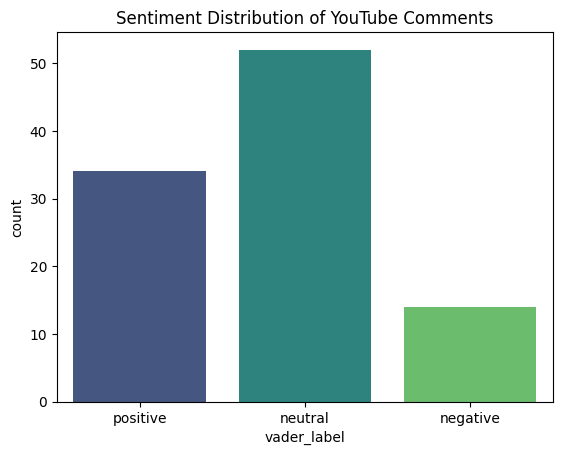

In [81]:
sns.countplot(data=df, x='vader_label', palette="viridis")
plt.title('Sentiment Distribution of YouTube Comments')
plt.show()

##### Using Word Cloud

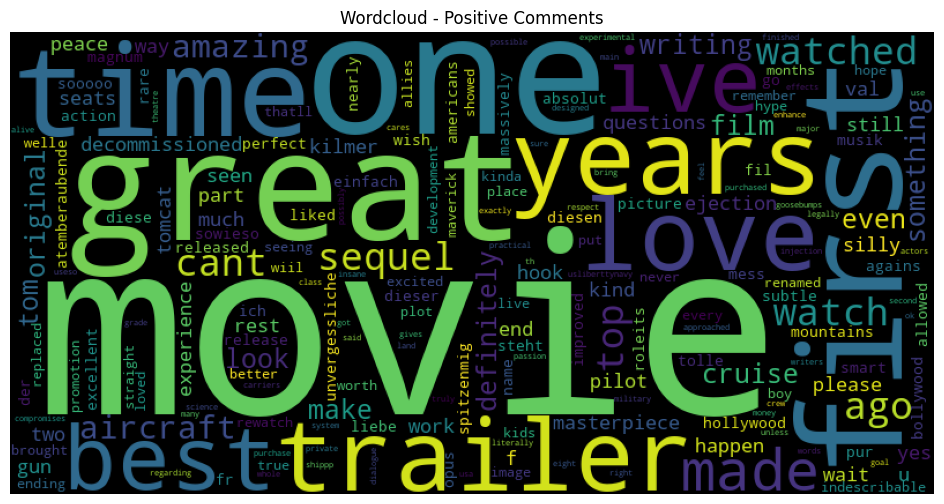

In [82]:
plt.figure(figsize=(12,6))
text_pos=" ".join(df[df.vader_label=='positive'].clean_text)
wc_pos=WordCloud(width=800, height=400).generate(text_pos)
plt.imshow(wc_pos)
plt.axis("off")
plt.title("Wordcloud - Positive Comments")
plt.show()

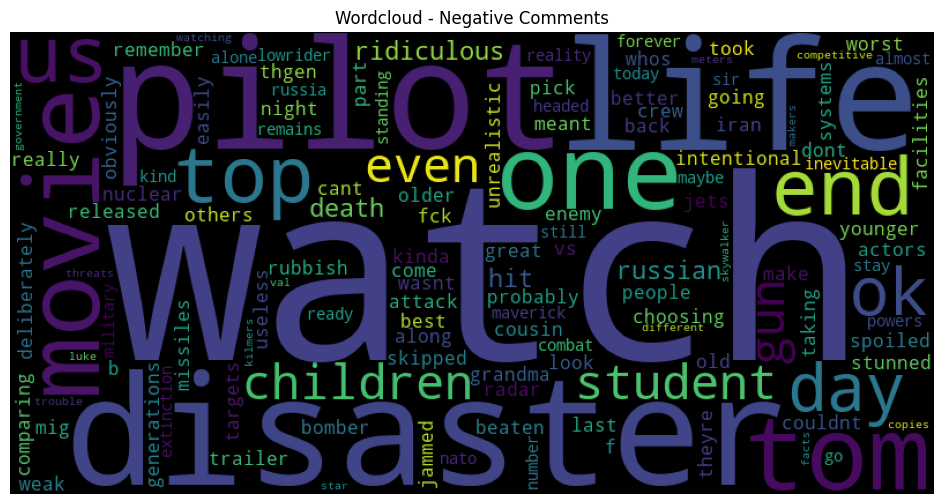

In [83]:
plt.figure(figsize=(12,6))
text_neg=" ".join(df[df.vader_label=='negative'].clean_text)
wc_neg=WordCloud(width=800, height=400).generate(text_neg)
plt.imshow(wc_neg)
plt.axis("off")
plt.title("Wordcloud - Negative Comments")
plt.show()

MODEL 2. BERT (HuggingFace pipeline)

In [84]:
bert_sentiment=pipeline('sentiment-analysis')
df['bert_label']=df['clean_text'].apply(bert_safe)
df['bert_label'].value_counts(dropna=True)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


bert_label
POSITIVE    59
NEGATIVE    41
Name: count, dtype: int64

In [85]:
df.head(20)

,author,text,likeCount,publishedAt,char_len,word_len,clean_text,vader_score,vader_label,bert_label
0,@DTM-ch7jy,This is one rare sequel that Hollywood did not...,0,2025-12-13T09:03:51Z,97,20,this is one rare sequel that hollywood did not...,0.6007,positive,POSITIVE
1,@tetsuyakohmatsu7268,革ジャンの背中に🇯🇵と🇹🇼があった時はほんと興奮した。\nアメリカ映画が中国には屈していなか...,0,2025-12-08T10:09:14Z,56,2,,0.0000,neutral,POSITIVE
2,@sandeokiii,i wish i could watch this movie for the first ...,0,2025-12-01T16:19:14Z,56,12,i wish i could watch this movie for the first ...,0.4019,positive,POSITIVE
3,@ewanijhof4687,its nerological fact,0,2025-11-30T00:18:07Z,20,3,its nerological fact,0.0000,neutral,POSITIVE
4,@ewanijhof4687,only pilots over 30 should be allowed to go ag...,0,2025-11-30T00:17:30Z,70,13,only pilots over should be allowed to go again...,0.3612,positive,NEGATIVE
5,@tine_9953,Ich liebe diese unvergessliche tolle atemberau...,0,2025-11-28T10:09:41Z,169,25,ich liebe diese unvergessliche tolle atemberau...,0.2023,positive,NEGATIVE
6,@HiboMohamed-q2l,Tom Cruise has a promotion contract with HH Fi...,0,2025-11-25T06:34:53Z,70,12,tom cruise has a promotion contract with hh fi...,0.0000,neutral,NEGATIVE
7,@soleidialvarez,Just watched this movie for the first time in ...,0,2025-11-13T04:44:22Z,113,20,just watched this movie for the first time in ...,0.9001,positive,POSITIVE
8,@Zz2br,Why can't Bollywood make something magnum opus...,0,2025-11-10T19:34:56Z,94,16,why cant bollywood make something magnum opus ...,0.3612,positive,POSITIVE
9,@FancyFreestyler,0:59\n1:38,2,2025-11-06T11:23:58Z,9,2,,0.0000,neutral,POSITIVE


COMPARISON OF VADER AND BERT

In [86]:
agree=(df['vader_label'].str.lower()==df['bert_label'].str.lower())
print('Agreement Rate: ', agree.mean())

pd.crosstab(df['vader_label'], df['bert_label'])

Agreement Rate:  0.38


bert_label,NEGATIVE,POSITIVE
vader_label,,
negative,11,3
neutral,23,29
positive,7,27


MODEL 3. EMOTION AND KEYWORD ANALYSIS

In [87]:
joy_words=['best', 'love', 'great', 'amazing', 'kind']             # emotion lexicons 
sad_words=['ridiculous', 'disaster', 'worst', 'hate', 'awful']

df['joy_score']=df['clean_text'].apply(lambda x: emotion_count(x, joy_words))
df['sad_score']=df['clean_text'].apply(lambda x: emotion_count(x, sad_words))

df[['joy_score', 'sad_score']].describe()                           # On average, each comment contains 0.21 joy words and 0.04 sad words.

,joy_score,sad_score
count,100.00000,100.000000
mean,0.21000,0.040000
std,0.53739,0.242878
min,0.00000,0.000000
25%,0.00000,0.000000
50%,0.00000,0.000000
75%,0.00000,0.000000
max,2.00000,2.000000


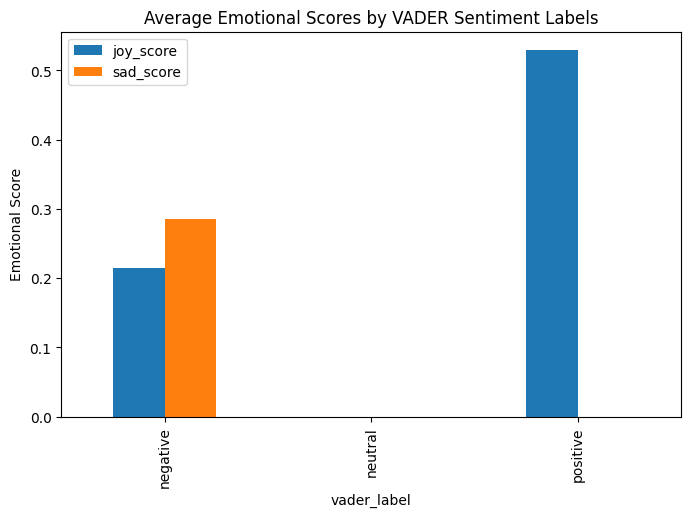

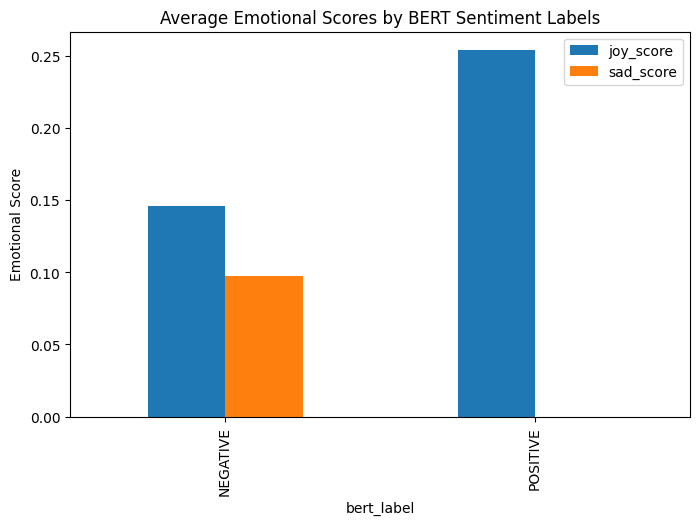

In [88]:
# Plot average emotional score by VADER/BERT sentiment
emo_means_vader=df.groupby('vader_label')[['joy_score', 'sad_score']].mean()
emo_means_bert=df.groupby('bert_label')[['joy_score', 'sad_score']].mean()

emo_means_vader.plot(kind='bar', figsize=(8,5))
plt.title('Average Emotional Scores by VADER Sentiment Labels')
plt.ylabel('Emotional Score')
plt.show()                              # shows better match with VADER

emo_means_bert.plot(kind='bar', figsize=(8,5))
plt.title('Average Emotional Scores by BERT Sentiment Labels')
plt.ylabel('Emotional Score')
plt.show()

MODEL 4. TOPIC MODELING (LDA)

In [89]:
vectorizer=CountVectorizer(stop_words='english', min_df=4)
X=vectorizer.fit_transform(df['clean_text'])        # 100 comments and 375 words

lda=LatentDirichletAllocation(n_components=5, random_state=42, learning_method='batch')
lda.fit(X)                                          # 100 comments and 5 topics

words=vectorizer.get_feature_names_out()

print_topics(lda, words)      # Select top 10 most weighted words per topic

Topic #0: did, movies, love, time, come, tom, trailer, watch, end, movie
Topic #1: great, time, gun, watch, ago, love, tom, years, movie, like
Topic #2: gun, love, did, time, best, great, movies, seen, movie, ive
Topic #3: years, time, movie, gun, tom, did, watch, released, film, trailer
Topic #4: movie, watch, tom, trailer, gun, end, come, kilmer, val, rip


MODEL 5. TF-IDF + LOGISTIC REGRESSION SENTIMENT CLASSIFIER

In [90]:
tfidf=TfidfVectorizer(stop_words='english', min_df=4)
X_tfidf=tfidf.fit_transform(df['clean_text'])        # TF-IDF features: 100 comments and 375 words
y_tfidf=df['bert_label']

X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test=train_test_split(
    X_tfidf, y_tfidf, test_size=0.2, random_state=42, stratify=y_tfidf
)

clf=LogisticRegression(class_weight='balanced', max_iter=1000)
clf.fit(X_tfidf_train, y_tfidf_train)

y_pred = clf.predict(X_tfidf_test)


print('Test Accuracy: ', clf.score(X_tfidf_test, y_tfidf_test))
print(classification_report(y_tfidf_test, y_pred))

Test Accuracy:  0.65
              precision    recall  f1-score   support

    NEGATIVE       1.00      0.12      0.22         8
    POSITIVE       0.63      1.00      0.77        12

    accuracy                           0.65        20
   macro avg       0.82      0.56      0.50        20
weighted avg       0.78      0.65      0.55        20



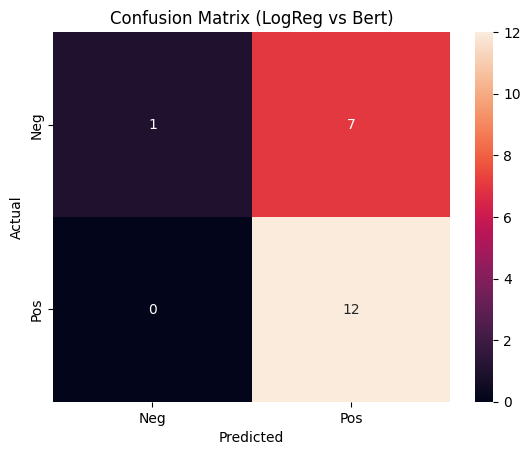

In [92]:
cm=confusion_matrix(y_tfidf_test, y_pred, labels=['NEGATIVE', 'POSITIVE']) # Actual/Predicted
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Neg', 'Pos'],
            yticklabels=['Neg', 'Pos'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (LogReg vs Bert)')
plt.show()

MODEL COMPARISON

In [94]:
model_summary = {
    "Model": ["VADER", "BERT pipeline", "LogReg + TF-IDF"],
    "Type": ["Rule-based", "Transformer", "Classical ML"],
    "Goal": [
        "Quick heuristic sentiment",
        "Semantic sentiment on raw text",
        "Learn to mimic VADER labels"
    ],
    "Pros": [
        "Fast, no training needed",
        "Best semantic understanding",
         "Interpretable weights, lightweight"
    ],
    "Cons": [
        "Noisy labels, bad on sarcasm",
        "Slower, heavier, black-box",
        "Inherits VADER noise, bag-of-words"
    ]
}

pd.DataFrame(model_summary)


,Model,Type,Goal,Pros,Cons
0,VADER,Rule-based,Quick heuristic sentiment,"Fast, no training needed","Noisy labels, bad on sarcasm"
1,BERT pipeline,Transformer,Semantic sentiment on raw text,Best semantic understanding,"Slower, heavier, black-box"
2,LogReg + TF-IDF,Classical ML,Learn to mimic VADER labels,"Interpretable weights, lightweight","Inherits VADER noise, bag-of-words"
